In [ ]:
# for Colab
!pip install botorch

In [4]:
import torch
import botorch
import gpytorch

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt

from generate_gp_data import GaussainProcessRandomDataset, FunctionSamplesDataset
from predict_EI_simple import calculate_EI_GP
from utils import get_uniform_randint_generator, get_param_value


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [2]:
def plot_gp_posterior(ax, posterior, test_x, train_x, train_y, color, name=None):
    lower, upper = posterior.mvn.confidence_region()
    mean = posterior.mean.squeeze().cpu().numpy()
    lower = lower.squeeze().cpu().numpy()
    upper = upper.squeeze().cpu().numpy()

    train_x = train_x.squeeze().cpu().numpy()
    train_y = train_y.squeeze().cpu().numpy()
    test_x = test_x.squeeze().cpu().numpy()

    extension = '' if name is None else f' {name}'

    # Plot training points as black stars
    ax.plot(train_x, train_y, f'{color}*', label=f'Observed Data{extension}')
    # Plot posterior means as blue line
    ax.plot(test_x, mean, color, label=f'Mean{extension}')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower, upper, color=color, alpha=0.5, label=f'Confidence{extension}')


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


likelihood.noise_covar.raw_noise Parameter containing:
tensor([1.0000e-06], requires_grad=True)

mean_module.raw_constant Parameter containing:
tensor(0., requires_grad=True)

covar_module.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)

covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([1.0000e-06])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(0.)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('mean_module.raw_constant', tensor(0.)), ('covar_module.raw_outputscale', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])), ('covar_module.base_kernel.lengthscale_prior.concentration', tensor(3.)), ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)), ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.base_kernel.raw_lengthscale_constrain

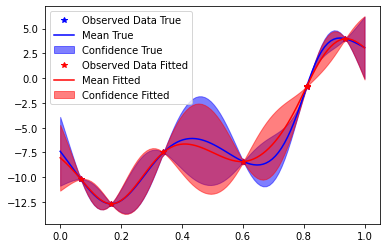

In [3]:
# randint_gen = get_uniform_randint_generator(4, 20)
# dataset = GaussainProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=randint_gen, observation_noise=False,
#     device=device)

# torch.manual_seed(1703)

OBSERVATION_NOISE = False

dataset = GaussainProcessRandomDataset(
    dimension=1, n_datapoints=7, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=True, device=device)

for name, param in dataset.model_sampler.get_model(0).named_parameters(): 
    print(name, param)
    print()

print(dataset.model_sampler.get_model(0).state_dict())

x_values, y_values, model = next(dataset)

true_lengthscale = model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
true_outputscale = model.covar_module.outputscale.squeeze().detach().numpy()
true_noise = model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()

test_x = torch.linspace(0, 1, 100, device=device)

# Get posterior under true model parameters
posterior_true = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)


for name, param in model.named_parameters(): 
    print(name, param)
    print()


# Get posterior by fitting by MAP
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
posterior_fitted = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)
fitted_model = model

fitted_lengthscale = fitted_model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
fitted_outputscale = fitted_model.covar_module.outputscale.squeeze().detach().numpy()
fitted_noise = fitted_model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()


with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    description_true   = f'True:   l={  true_lengthscale:.3g}, sigma^2={  true_outputscale:.3g}, noise={true_noise:.3g}'
    description_fitted = f'Fitted: l={fitted_lengthscale:.3g}, sigma^2={fitted_outputscale:.3g}, noise={fitted_noise:.3g}'
    print(description_true)
    print(description_fitted)
    
    plot_gp_posterior(ax, posterior_true, test_x, x_values, y_values, 'b', name='True')
    plot_gp_posterior(ax, posterior_fitted, test_x, x_values, y_values, 'r', name='Fitted')

    ax.legend()

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


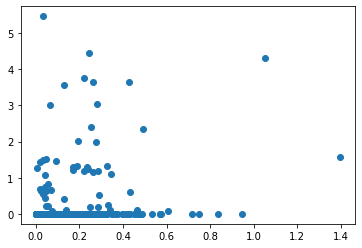

In [6]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()


OBSERVATION_NOISE = False
dataset = GaussainProcessRandomDataset(
    dimension=5, n_datapoints=20, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=False, device=device)

n_samples = 1000

ei_values = torch.empty(n_samples, device=device)
improvement_values = torch.empty(n_samples, device=device)


with torch.no_grad():
    for i in range(n_samples):
        x_values, y_values, random_model = next(dataset)

        # x_values is shape (n_datapoints, dimension)
        # y_values is shape (n_datapoints,)
        x_hist = x_values[:-1, :]
        y_hist = y_values[:-1]
        x = x_values[-1:, :]
        y = y_values[-1:]
        
        ei_value, improvement_value = calculate_EI_GP(random_model, x_hist, y_hist, x, y, fit_params=False)
        ei_values[i] = ei_value[0]
        improvement_values[i] = improvement_value[0]

    # print(ei_values)
    # print(improvement_values)


# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

plt.scatter(ei_values.cpu().numpy(), improvement_values.cpu().numpy())

In [29]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end > start, "this example code only works with end >= start"
        self.start = start
        self.end = end

    def __iter__(self):
        return iter(range(self.start, self.end))

for x in MyIterableDataset(3, 7):
    print(x)


3
4
5
6


In [36]:
u = torch.rand(8, 3)
print(u)
rand_indices = torch.randperm(u.shape[0])
print(rand_indices)
print(u[rand_indices])
print(u[rand_indices[:3]])
print(u[rand_indices[3:]])

tensor([[0.4321, 0.9570, 0.2413],
        [0.7917, 0.6027, 0.1502],
        [0.7692, 0.3887, 0.8973],
        [0.2957, 0.0481, 0.0261],
        [0.6843, 0.2177, 0.8816],
        [0.1277, 0.4359, 0.3886],
        [0.0205, 0.9009, 0.2009],
        [0.2266, 0.2300, 0.7466]])
tensor([2, 6, 5, 4, 3, 0, 7, 1])
tensor([[0.7692, 0.3887, 0.8973],
        [0.0205, 0.9009, 0.2009],
        [0.1277, 0.4359, 0.3886],
        [0.6843, 0.2177, 0.8816],
        [0.2957, 0.0481, 0.0261],
        [0.4321, 0.9570, 0.2413],
        [0.2266, 0.2300, 0.7466],
        [0.7917, 0.6027, 0.1502]])
tensor([[0.7692, 0.3887, 0.8973],
        [0.0205, 0.9009, 0.2009],
        [0.1277, 0.4359, 0.3886]])
tensor([[0.6843, 0.2177, 0.8816],
        [0.2957, 0.0481, 0.0261],
        [0.4321, 0.9570, 0.2413],
        [0.2266, 0.2300, 0.7466],
        [0.7917, 0.6027, 0.1502]])


In [45]:
q = torch.rand(20)
q - 10.0

tensor([-9.5747, -9.7501, -9.6260, -9.5177, -9.1595, -9.5724, -9.6298, -9.1459,
        -9.6044, -9.6240, -9.6702, -9.5881, -9.5899, -9.7063, -9.1460, -9.7534,
        -9.3527, -9.5060, -9.5050, -9.8674])

In [48]:
type(dataset)

predict_EI_simple.GaussainProcessRandomDataset

In [50]:
list[dict]

list[dict]

In [49]:
isinstance(dataset, torch.utils.data.IterableDataset)

True

In [53]:
dataset.__class__.__name__

'GaussainProcessRandomDataset'

In [58]:
{x:y for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([0.], requires_grad=True),
 'mean_module.raw_constant': Parameter containing:
 tensor(0.0074, requires_grad=True),
 'covar_module.raw_outputscale': Parameter containing:
 tensor(14.9644, requires_grad=True),
 'covar_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[0.8065]], requires_grad=True)}

In [59]:
{x:y.detach() for x, y in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': tensor([0.]),
 'mean_module.raw_constant': tensor(0.0074),
 'covar_module.raw_outputscale': tensor(14.9644),
 'covar_module.base_kernel.raw_lengthscale': tensor([[0.8065]])}

In [22]:
model.index

0

In [26]:
fixed_dataset = FunctionSamplesDataset.from_gp_random_dataset(dataset, 1000)
fixed_dataset.save("data")

In [30]:
fixed_dataset[0][0]

tensor([[0.8489, 0.1965, 0.0284, 0.0234, 0.1666],
        [0.8518, 0.9975, 0.9318, 0.0532, 0.1928],
        [0.9660, 0.5656, 0.1563, 0.1609, 0.0425],
        [0.4375, 0.4648, 0.2420, 0.1713, 0.9196],
        [0.0546, 0.8694, 0.4443, 0.5036, 0.8704],
        [0.9682, 0.4215, 0.7049, 0.4719, 0.8775],
        [0.6631, 0.9408, 0.6663, 0.5284, 0.6014],
        [0.8294, 0.9148, 0.5544, 0.8021, 0.8817],
        [0.7465, 0.8460, 0.5765, 0.1917, 0.8225],
        [0.2578, 0.8584, 0.0147, 0.4841, 0.8581],
        [0.8904, 0.7481, 0.0781, 0.5039, 0.5400],
        [0.1587, 0.6665, 0.6906, 0.8259, 0.9701],
        [0.1105, 0.4084, 0.0324, 0.1800, 0.1766],
        [0.9080, 0.4782, 0.8625, 0.7269, 0.8146],
        [0.5159, 0.9522, 0.1116, 0.6569, 0.7407],
        [0.7568, 0.2690, 0.5293, 0.2926, 0.5500],
        [0.6386, 0.7783, 0.5267, 0.3157, 0.0216],
        [0.3528, 0.7596, 0.1990, 0.9174, 0.3976],
        [0.2512, 0.9899, 0.4709, 0.1600, 0.5643],
        [0.7841, 0.6821, 0.1907, 0.4530, 0.0499]])

In [33]:
fixed_dataset_loaded = FunctionSamplesDataset.load("data")
fixed_dataset_loaded[0][2].index

0

In [7]:
# test_dataset = FunctionSamplesDataset([
#     {'x_values': [i], 
#      'y_values': [i]}
#      for i in range(20)
# ] + [{'x_values': [12, 13], 'y_values': [33]}])

test_dataset = GaussainProcessRandomDataset(
    dimension=2, n_datapoints=4, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=False, device=device)


data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,
                                        #   sampler=torch.utils.data.RandomSampler(test_dataset, replacement=False, num_samples=200)
                                          )


In [8]:
class FirstNIterable:
    def __init__(self, iterable, n):
        self.iterable = iterable
        self.n = n
    
    def __iter__(self):
        iterator = iter(self.iterable)
        for _ in range(self.n):
            try:
                yield next(iterator)
            except StopIteration:
                break

first3 = FirstNIterable(test_dataset, 3)
first5 = FirstNIterable(first3, 5)
for a,b,c in first5:
    print(b)

tensor([-3.8186, -0.1947, -4.2731, -4.8191])
tensor([2.0626, 1.2860, 3.2079, 2.8453])
tensor([-1.4478, -2.5589,  0.8257,  0.8572])


In [37]:
hasattr(test_dataset, '_model_sampler')

False

In [9]:
words = ["apple", "banana", "cherry", "date"]
first_two = FirstNIterable(words, 2)
list(first_two)

['apple', 'banana']

In [10]:
numbers = range(10)
first_five = FirstNIterable(numbers, 5)
list(first_five)

[0, 1, 2, 3, 4]